# PYBOR
PYBOR is a multi-curve interest rate framework and risk engine based on multivariate optimization techniques, written in Python.

**Copyright &copy; 2017 Ondrej Martinsky, All rights reserved**

[www.github.com/omartinsky/pybor](https://github.com/omartinsky/pybor)

In [1]:
%pylab
%matplotlib inline
%run jupyter_helpers
%run yc_framework
figure_width = 16

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


## Pricing Curve Map
Generate pricing curvemap using stochastic short-rate model $dr_t=a(b-r_t)dt + \sigma dW_t$ for curves and tenor/cross-currency basis spreads. This will be our starting point, the curves inside this curvemap will be used only to reprice market instruments.

In [2]:
eval_date = create_date('2017-01-03')

In [3]:
def generate_pricing_curvemap(eval_date):
    random.seed(0)
    pricing_curvemap = CurveMap()
    t = linspace(eval_date+0, eval_date+365*80, 7)
    def createCurve(name, r0, speed, mean, sigma):
        return CurveConstructor.FromShortRateModel(name, t, r0, speed, mean, sigma, interpolation=InterpolationMode.CUBIC_LOGDF)
    def createCurveFromSpread(baseCurve, name, r0, speed, mean, sigma):
        out = createCurve(name, r0, speed, mean, sigma)
        out.add_another_curve(baseCurve)
        return out
    u3m = createCurve('USDLIBOR3M', 0.02, 0.03, 0.035, 5e-4)
    u6m = createCurveFromSpread(u3m, 'USDLIBOR6M', 0.01, 0.03, 0.011, 5e-4)
    u12m = createCurveFromSpread(u6m, 'USDLIBOR12M', 0.01, 0.03, 0.011, 5e-4)
    g3m = createCurveFromSpread(u3m, 'GBPLIBOR3M', 0.03, 0.03, 0.0, 5e-4)
    u1b = createCurve('USD-USDOIS', 0.01, 0.03, 0.011, 5e-4)
    g1b = createCurveFromSpread(u1b, 'GBP-GBPSONIA', 0.005, 0.03, 0.005, 5e-4)
    gu1b = createCurveFromSpread(u1b, 'GBP-USDOIS', 0.001, 0.03, 0.001, 5e-4)
    pricing_curvemap.add_curve(u3m)
    pricing_curvemap.add_curve(u6m)
    pricing_curvemap.add_curve(u12m)
    pricing_curvemap.add_curve(g3m)
    pricing_curvemap.add_curve(g1b)
    pricing_curvemap.add_curve(u1b)
    pricing_curvemap.add_curve(gu1b)
    return pricing_curvemap

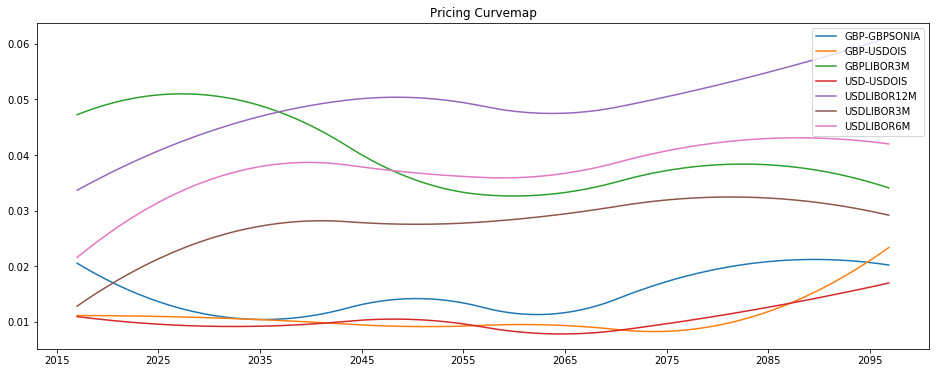

In [4]:
pricing_curvemap = generate_pricing_curvemap(eval_date)
# Display:
figsize(figure_width, 6)
linestyle('solid'), pricing_curvemap.plot(), title('Pricing Curvemap'), legend(), show();

## Interpolation Modes
PYBOR supports three different interpolation methods:
* Linear interpolation of the logarithm of discount factors (aka piecewise-constant in forward-rate space)
* Linear interpolation of the continuously-compounded zero-rates
* Cubic interpolation of the logarithm of discount factors 

Below is the curve interpolated in three different ways:

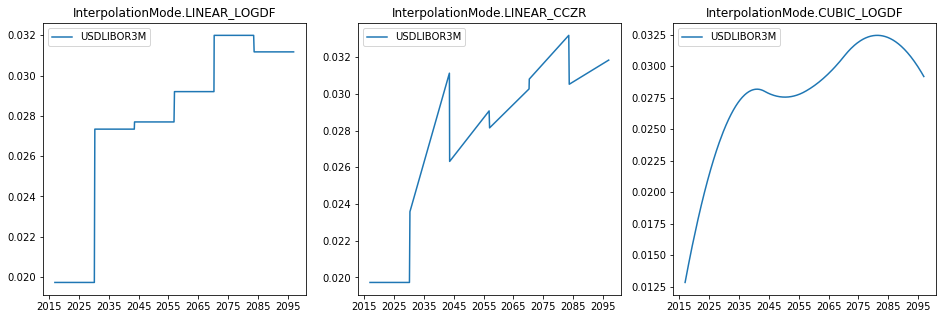

In [5]:
cloned_curve = deepcopy(pricing_curvemap['USDLIBOR3M'])
figsize(figure_width, 5)
for i, interpolation in enumerate(InterpolationMode._member_map_.values()):
    cloned_curve.set_interpolator(interpolation)
    subplot(1,3,i+1), title(interpolation), cloned_curve.plot(), legend()

## Curve Builder
Create the curve builder. Definitions of curves and market instruments from which these curves are built are loaded from the excel spreadsheet

In [6]:
curve_builder = CurveBuilder('engine_usd_gbp.xlsx', eval_date, progress_monitor=ProgressMonitor())

### Instrument Repricing
Use the curve builder (specifically instrument definitions which it contains) to **reprice** instruments from previously created **pricing curve map**.

Instrument *prices* are returned in a structure called *price ladder*

In [7]:
price_ladder = curve_builder.reprice(pricing_curvemap)

### Display price ladder for a specific curve

In [8]:
# Display:
figsize(figure_width, 4)
price_ladder.sublist('USDLIBOR3M').dataframe()

,Price
USDLIBOR3M__Deposit__3M,1.314057
USDLIBOR3M__Future__1F_3M,98.654048
USDLIBOR3M__Future__2F_3M,98.622132
USDLIBOR3M__Future__3F_3M,98.590405
USDLIBOR3M__Future__4F_3M,98.559413
USDLIBOR3M__Future__5F_3M,98.528839
USDLIBOR3M__Future__6F_3M,98.498258
USDLIBOR3M__Future__7F_3M,98.467879
USDLIBOR3M__Future__8F_3M,98.438231
USDLIBOR3M__Future__9F_3M,98.408978


### Display instrument par-rates
Every instrument type has a specific relationship between the quoted price $P$ and the par-rate $r$. For instance:

For interest rate swaps, $P = 100 \times r$

For interest rate futures, $P = 10000 \times (1 - r)$

The relationship between interest rate curve in a **zero-rate** space and instrument **par-rates** is often a source of confusion for many people. The below is a graph which illustrates the difference between USDLIBOR3M pricing curve's zero rates vs. par-rates of instruments (e.g. deposits, futures, swaps), which are repriced using this curve.
As we can see, only the par-rates of money market (deposit) instruments correspond to the curve points plotted in a zero-rate space.

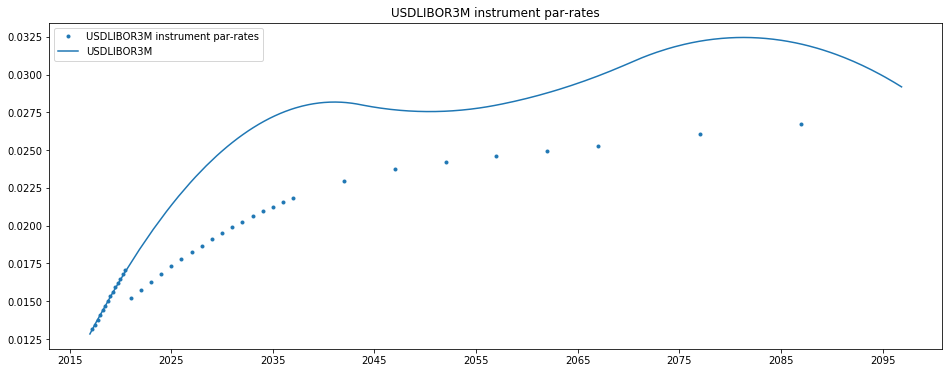

In [ ]:
figsize(figure_width, 6)
m, r = curve_builder.get_instrument_rates(price_ladder.sublist('USDLIBOR3M'))
m = [fromexceldate(int(i)) for i in m]
title('USDLIBOR3M instrument par-rates')
linestyle(' '), plot(m,r,marker='.', label='USDLIBOR3M instrument par-rates')
linestyle('-'), pricing_curvemap['USDLIBOR3M'].plot()
legend();

### Curve Building
Build a brand new collection of curves from the instrument prices. This will take few seconds to complete ... 

In [ ]:
build_output = curve_builder.build_curves(price_ladder)

Creating pillars 0 - 39 for curve USDLIBOR3M
Creating pillars 39 - 69 for curve USDLIBOR6M
Creating pillars 69 - 99 for curve USDLIBOR12M
Creating pillars 99 - 132 for curve USD-USDOIS
Creating pillars 132 - 171 for curve GBPLIBOR3M
Creating pillars 171 - 204 for curve GBP-GBPSONIA
Creating pillars 204 - 234 for curve GBP-USDOIS
.........

Below is the comparison of curves which we have just built (**solid lines**) with pricing curves (**dotted lines**). These lines should be as close to each other as possible.

In [ ]:
# Display:
figsize(figure_width, 6)
title('Curvebuilder output')
linestyle('solid'), build_output.output_curvemap.plot(), legend()
linestyle('dotted'), pricing_curvemap.plot();

### Instrument/Pillar Jacobian Matrix
The optimizer is using gradient-descent method to minimize error between instrument par-rates calculated from the curves which are subject to this optimization and the input instrument par-rates. In order to do this, optimizer calculates derivative ${\delta (I-I') / \delta P}$, where $I$ is the actual instrument par-rate, $I'$ is the target instrument par-rate and $P$ is the pillar value from the curve (practically speaking, the discount factor).

Jacobian matrix which is a by-product of the curve building process can be then used for risk calculation purposes and it will be illustrated lated.

In [ ]:
jacobian_dPdI = inv(build_output.jacobian_dIdP)
# Display:
figsize(figure_width, 8)
title("Jacobian Matrix"), xlabel('Pillars'), ylabel('Instruments')
imshow(jacobian_dPdI), colorbar();

## Risk Calculator
Risk calculator is constructed from the **curve builder** (which contains curve definitions and market conventions) and **build output** (which contains curves and the jacobian matrix).

In [ ]:
risk_calculator = RiskCalculator(curve_builder, build_output)

Let's define a convenience function which will bump par-rate of a specific instrument by the given amount of basis points and visualise the effect on all curves.

In [ ]:
def visualise_bump(instrument_search_string, bumpsize):
    instruments, bumpsize = risk_calculator.find_instruments(instrument_search_string), bumpsize  
    curvemap_bump = risk_calculator.get_bumped_curvemap(instruments, bumpsize, BumpType.JACOBIAN_REBUILD)

    # Display:
    figsize(figure_width, 6)
    linestyle('solid'), build_output.output_curvemap.plot(), legend()
    linestyle('dashed'), curvemap_bump.plot()
    title("Effect of bumping instrument %s" % instrument_search_string)

### Bumping Market Instruments

Bumping **market instruments** (such as those which define USD LIBOR 3M neutral curve) will cause parallel shift of all other curves which are defined as a basis from this curve

In [ ]:
visualise_bump('USDLIBOR3M__Swap__20Y', 1e-4)

In [ ]:
visualise_bump('USDLIBOR3M.*', 15e-4)

## Bumping Basis Instruments

Bumping **basis instruments** (USD LIBOR 6M) will cause movement in a USD LIBOR 6M basis curve

In [ ]:
visualise_bump('USDLIBOR6M__BasisSwap__20Y', 1e-4)

In [ ]:
visualise_bump('USDLIBOR6M.*', 15e-4)